**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# Using SVM with a linear kernel for music genre classification.

## Abstract

## 1. Introduction

### 1.1 Problem statement
Is it possible to classify music into genres using features that are 'clumped' together using a bag-of-frames model. Furthermore, is it possible to achieve good results using basic ML techniques? In this project we want to classify songs into one of 10 genres: 'Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues'. The songs have been transformed into numerical features, describing various sound characteristics. These features include MFCCs, Chroma, Rhythm patterns and their deltas and delta-deltas. 

### 1.2 Motivation
Human beings are able perform the same classification task upon hearing music, so this should at least in theory be possible to do with a machine. However, since the classification task performed on raw spectrogram data of a sound file would be extremely computationally expensive, and using the recursive nature of the time-domain waveform requires advanced ML techniques. It would therefore be interesting to discover whether it would be possible to classify the songs when the features are in a compressed form, such as a bag-of-frames model. This kind of approach has many benefits and some drawbacks: It is independent of song length and basic classification techniques can be used, but on the other hand features are harder to interpret. 

The dataset contains 264 features of different sound characteristics of the whole audio file.



## 2. Data analysis

In this section we cover analysis of the dataset. In other words, we take a close look at the data and try to make observations about it that will be beneficial during the training phase.

In [1]:
# Import libraries
import visu_utils as vu
import data_utils as du
import pandas as pd
import numpy as np

We start by importing the data as csv files to Pandas DataFrames. The raw data consists of 4363 datapoints, each with 264 features. All the functions used for data analysis can be found in visu_utils (for visualizing functions) and data_utils (for data processing and transformation functions)

In [2]:
# Import data
data_file = 'kaggle_data/train_data.csv'
labels_file = 'kaggle_data/train_labels.csv'
data, labels = du.Import_Data(data_file, labels_file)

Imported data (4363, 264) and labels (4363, 1).


### 2.1. Label representation
We start by analyzing the distribution of labels of the dataset. The goal would be to have as uniform distribution as possible.

As can be observed below, there are disproportionally many samples of label 1 (Pop/Rock), and a slight overrepresentation of label 2. This might be taken into account in the preprocessing stage. The alternatives of approaching this problem could be: 
1. Augmenting the dataset (e.g. resampling)
2. Modifying the loss function (e.g. by penalizing misclassification of minority classes more)
3. Utilizing ensemble methods (e.g. "bagging")

Frequency of labels in percentage:
Label 1 : 2178 samples, frequency: 49.920 %
Label 2 : 618 samples, frequency: 14.165 %
Label 3 : 326 samples, frequency: 7.472 %
Label 4 : 260 samples, frequency: 5.959 %
Label 5 : 253 samples, frequency: 5.799 %
Label 6 : 214 samples, frequency: 4.905 %
Label 7 : 195 samples, frequency: 4.469 %
Label 8 : 141 samples, frequency: 3.232 %
Label 9 : 92 samples, frequency: 2.109 %
Label 10 : 86 samples, frequency: 1.971 %


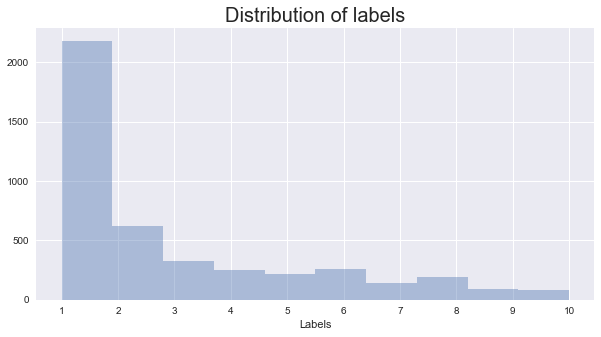

In [3]:
# Histogram of label distribution
vu.label_distribution(labels.values,size=(10,5))

### 2.2. Feature analysis 
#### 2.2.1 Variance 
Next, we will analyze the features. It is important that the features are normalized before calculating the final variance, so that all the resulting variances will be in the same range. With this normalization step it is possible to directly compare the variances. 

4 features with zero-variance were detected. These can directly be dismissed, because they contain no information. A majority (about 40%) of the rest of the features have a variance lower than 0.015. These features might be less significant, but it is hard to say at this stage whether it is worth keeping them for the training. This might be taken into account during the preprocessing. One idea would be to test to drop features with normalized variance below a certain threshold and see how it affects the classification. The benefit of dropping this many features would be great, as the training time could potentially be dramatically reduced. 

Zero variance features removed from data. Input shape: (4363, 264). Output shape: (4363, 260).
10 :th percentile:  0.014831916303804352
20 :th percentile:  0.014837838120658402
30 :th percentile:  0.014838503426721324
40 :th percentile:  0.014842608635116591
50 :th percentile:  0.038657677298818874
60 :th percentile:  0.06610638918252043
70 :th percentile:  0.14190034613989205
80 :th percentile:  0.32928821955729215
90 :th percentile:  0.6004243178683137


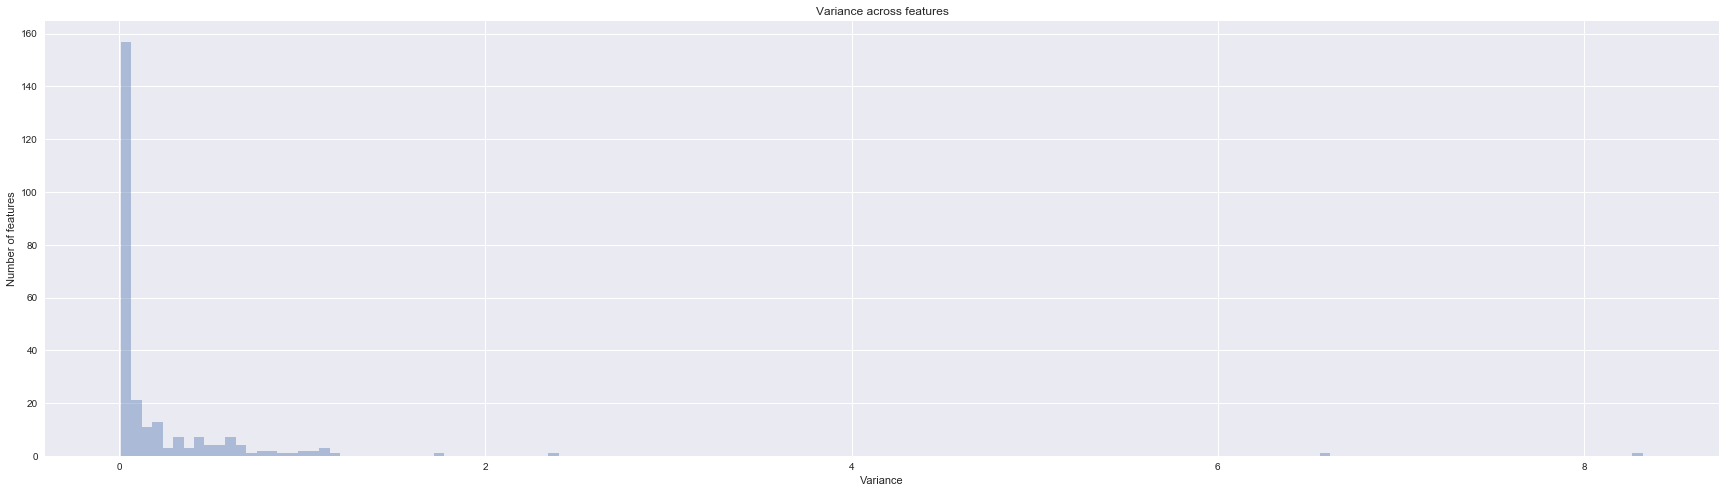

In [4]:
vu.feature_variances(data)

#### 2.2.2 Correlation
Next, let's look at mutual correlation of all the features. This can be visualized with the correlation matrix heat map below. Feature pairs with high enough correlation would indicate that one of them is redundant, and could thus be dismissed.
No features with correlation of 1 were found, but the highest correlation of 0.995 is relatively high. 6 feature pairs with a correlation of higher than 0.995 were found. These might be dismissed (only one of the pairs, of course) during the preprocessing. Again, it might be useful to test the classification after and before dropping the features in order to investigate whether they have any impact on the classification performance.

Zero variance features removed from data. Input shape: (4363, 264). Output shape: (4363, 260).
Largest correlation:  0.9953987162062764
Indeces with stronger correlance than  0.995 :
 [ 14  15  16 110 111 112] 
 [110 111 112  14  15  16]
Correlation of percentile  99 :  0.691365120369371


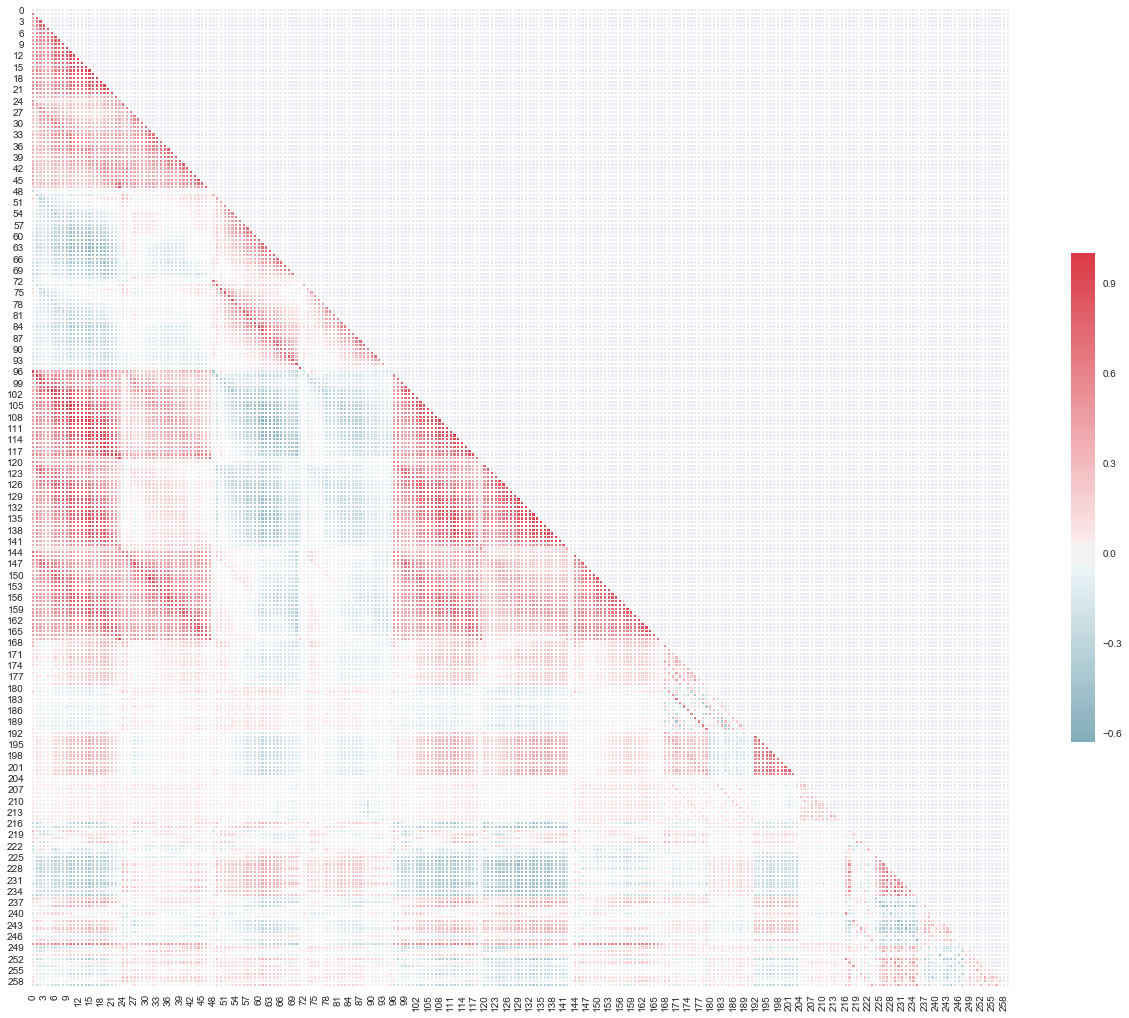

In [5]:
cor_m = vu.feature_correlations(data)

#### 2.2.2 Testing feature importance
Next, we will test removing some features and see whether it has any effect on classification. For this, we will use a quick-and-dirty simplistic XGBoost random forest classifier. At the same time it is a good opportunity to familiarize ourselves with different methods for evaluating classification performance and get a reference score we can compare with more refined models at a later stage. 

First, let's add all the less important features (that is, what we hypothesize are less important) to a list.
At this stage, we have to define a low threshold for variance and high threshold for correlation. We'll use the previous threshold for correlation for now, but allow for some tweaking of the variance threshold.

In [6]:
var_thresh = 0.0146

Finding features with low variance....

In [7]:
low_variances = du.Low_variance(data.values,var_thresh)
low_variances_ = ['f22', 'f23', 'f46', 'f118', 'f119', 'f124', 'f129', 'f140', 'f141', 'f142']
print("Features with lowest variance: ",low_variances)

AttributeError: module 'data_utils' has no attribute 'Low_variance'


Next, we will do a quick-and-dirty train round with XGBoost to find out a rough estimation of the importance of these features based on the Gini factor

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Data successfully split. Test data ratio = 0.3
Minimum importance:  1
Maximum importance:  79


NameError: name 'low_variances_' is not defined

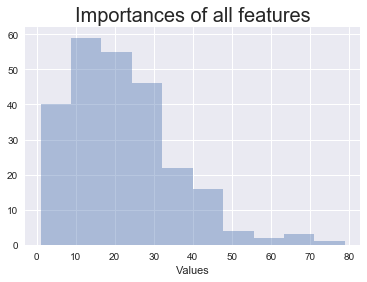

In [8]:
import learning_utils as lu
y = labels.values
X = data.values
X_train, X_test, y_train, y_test = du.Split_Data(X,y)
bst = lu.Learn_XGBoost(X_train,y_train,X_test,y_test,max_depth=500,num_round=50,use_weights=False)
import operator
importances = bst.get_score()
min_importance = importances[min(importances.items(), key=operator.itemgetter(1))[0]]
max_importance = importances[max(importances.items(), key=operator.itemgetter(1))[0]]
print("Minimum importance: ", min_importance)
print("Maximum importance: ", max_importance)
vu.hist(np.fromiter(importances.values(), dtype=float),title="Importances of all features")
low_variance_importance = [importances.get(key) for key in low_variances_]
print("Importance of low variance features: ", low_variance_importance)
importances_sorted = sorted(importances.items(), key=lambda kv: kv[1])
#print(importances_sorted)

The features seem to consist of a very few highly important features, while most of them lie in the low-importance region. 

All low variance features with importance below 10 will be chosen.

We will add the features with higher correlation than 0.995. We'll copy one of the feature list previously calculated.

In [9]:
low_variances = [22, 23, 46, 118, 119]
high_correlations = [14,15,16,110,111,112]

Then we'll merge these lists together. We want to avoid overlapping features with both high correlation and low variance so unique is used.

In [10]:
remove_features = list(np.unique(np.array(low_variances + high_correlations)))

In [11]:
X = data.values
X_reduced = np.delete(X,remove_features,axis=1)
print("Comparing original shape to reduced shape:")
print("Original: ", X.shape)
print("Reduced: ",X_reduced.shape)

Comparing original shape to reduced shape:
Original:  (4363, 264)
Reduced:  (4363, 253)


Next, both datasets, original and reduced, are trained with identical machine learning model. 

Training and testing the original features:


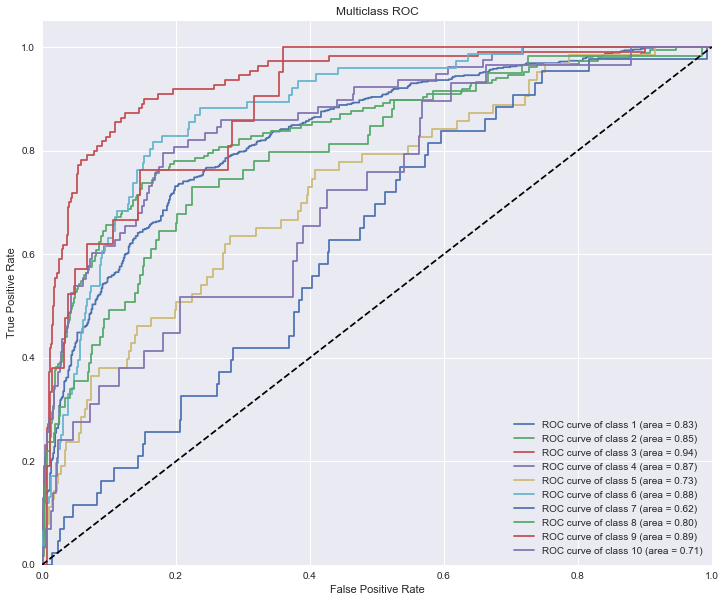

              precision    recall  f1-score   support

           1       0.69      0.84      0.76       644
           2       0.60      0.56      0.58       186
           3       0.62      0.61      0.61       110
           4       0.49      0.36      0.41        78
           5       0.24      0.19      0.21        63
           6       0.32      0.28      0.30        76
           7       0.00      0.00      0.00        43
           8       0.52      0.20      0.29        59
           9       0.26      0.24      0.25        21
          10       0.22      0.07      0.11        29

   micro avg       0.61      0.61      0.61      1309
   macro avg       0.40      0.33      0.35      1309
weighted avg       0.57      0.61      0.58      1309

Accuracy:  0.6073338426279603
Balanced Accuracy:  0.3349168115700881
Training and testing the reduced features:


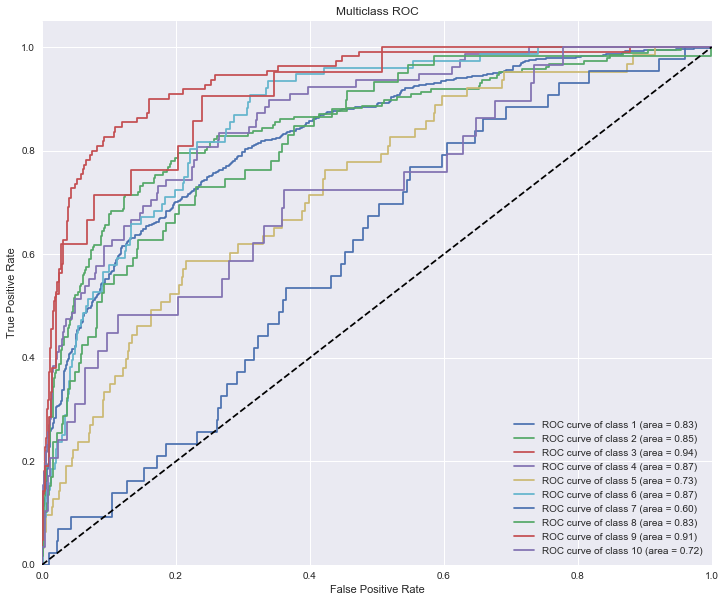

              precision    recall  f1-score   support

           1       0.68      0.84      0.75       644
           2       0.60      0.57      0.58       186
           3       0.63      0.58      0.61       110
           4       0.59      0.38      0.47        78
           5       0.22      0.19      0.20        63
           6       0.32      0.24      0.27        76
           7       0.00      0.00      0.00        43
           8       0.35      0.14      0.20        59
           9       0.24      0.24      0.24        21
          10       0.25      0.10      0.15        29

   micro avg       0.60      0.60      0.60      1309
   macro avg       0.39      0.33      0.35      1309
weighted avg       0.56      0.60      0.57      1309

Accuracy:  0.6027501909854851
Balanced Accuracy:  0.32839487714508386


In [12]:
X_red_train = np.delete(X_train,remove_features,axis=1)
X_red_test = np.delete(X_test,remove_features,axis=1)
print("Training and testing the original features:")
pred_labels, pred_labels_score = lu.XGB_Predict(bst,X_test,y_test)
vu.ROC_curve(y_test,pred_labels_score, fig_size=(12,10))
vu.performance_report(y_test,pred_labels)
print("Training and testing the reduced features:")
bst_red = lu.Learn_XGBoost(X_red_train,y_train,X_red_test,y_test,max_depth=500,num_round=50,use_weights=False)
pred_labels_red, pred_labels_score_red = lu.XGB_Predict(bst_red,X_red_test,y_test)
vu.ROC_curve(y_test,pred_labels_score_red, fig_size=(12,10))
vu.performance_report(y_test,pred_labels_red)

As can be shown, the removal of low variance-low "gini-importance" features did not drastically affect the performance of the classification. However, the slight decline in performance, off approx. 0.5% in accuracy of that small of a number of features dropped suggests that even the low-important features have some effect on the classification. In order to avoid loss of important information, more sophisticated dimensionality techniques might be used instead. 

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



### 3.1 Overview of methods
When choosing a learning method, you have to consider many different things: Which algorithm, what parameters to use, how to reduce overfitting, how to clean up data etc. During this project work, we played around with multiple different learning algorithms, such as support vector machines (SVM), neural networks, and random forests. Out of these, SVM gave the best result, with multilayer perceptron not far behind. In this report, we will focus on the support vector machine. 

The 'best' parameters were found using grid search over some arbitrarily chosen range of parameters. Performance is evaluated by splitting the data into train and test sets, and scoring based on accuracy. 

Additionally, the data is preprocessed before being fed to the SVM.

### 3.2 Preprocessing

In the data analysis step we removed features of very low importance and the remaining features were stored into the variable 'X_reduced'. Firstly and most importantly, the features should be normalized. Normalization is important for the performance of the SVM [1]. Note that unless zero variance features (i.e. constant columns) are removed, a division with zero will occur when normalizing with the most common methods. However, we removed these features in the data analysis section, so we do not need to do it here as well.

Normalization can be done in many ways, but we chose to implement three: Min-max normalization, Z-score normalization and tanh-normalization [2]. Respectively,
$$\mathbf{x}_{\mathrm{minmax}} = \frac{\mathbf{x}-\mathrm{min}(\mathbf{x})}{\mathrm{max}(\mathbf{x})-\mathrm{min}(\mathbf{x})}\\ $$
$$\mathbf{x}_{\mathrm{z}} = \frac{\mathbf{x}-\bar{\mathbf{x}}}{\mathrm{var}(\mathbf{x})}\\ $$
$$\mathbf{x}_{\mathrm{tanh}} = 0.5 (\mathrm{tanh}(0.01 \frac{\mathbf{x}-\bar{\mathbf{x}}}{\mathrm{var}(\mathbf{x})})+1) \\
$$

Another way is to use sklearn.preprocessing.StandardScaler(). In the end, StandardScaler resulted in better perfomance than our own normalization functions so we ended up using that. The StandardScaler is wrapped in our data_utils.Standardize()-function.

The code implementation can be found in data_utils.Normalization() in Appendices. Let's call the function here: 

In [14]:
normalized_features = du.Standardize(X_reduced)

Next we want to deal with the imbalance of the data, since, as noted in section 2, the dataset is heavily balanced towards label 1. Fortunately for us, there are a lot of tricks that can be used to try to balance the dataset. Most of these involve either oversampling the minority variables or undersampling the majority variable, collectively known as resampling. We chose to focus on undersampling of the majority variable, since less data means increased computational speed. Furthermore, undersampling means we can more easily track the 'true test labels', instead of using generated data as test data.

Many undersampling algorithms exist. We chose to focus on random undersampling and Tomek links. The former is quite self-explanatory, the latter removes data points from label boundary regions, which makes the data less noisy.[3] These resampling techniques are implemented in data_utils.Resample().

In [16]:
resampled_features, resampled_labels = du.Resample(normalized_features, labels, 'TomekLinks')

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampling complete. Sample amount changed from 4363 to 4272


Before splitting the data into test and train sets, we want to shuffle it, to (hopefully) reduce biases in either set. After that we can split the data.

In [17]:
shuffled_features, shuffled_labels = du.Shuffle(resampled_features, resampled_labels)
train_features, test_features, train_labels, test_labels = du.Split_Data(shuffled_features, shuffled_labels)

Data successfully shuffled
Data successfully split. Test data ratio = 0.3


### 3.2 Training the model
In this subsection we discuss the training of the model. More specifically, we introduce the algorithm that we used, how it was implemented and how we searched for the best parameters.

First, let's discuss our training algorithm: the support vector machine.

#### 3.2.1 The SVM
The support vector machine separates two classes by drawing a decision boundary between them. For example, in 2-D, the decision would be a line. For our data of size M x N, the decision boundary will be a N-1 dimensional hyperplane. [4] Note that our dataset contains 10 classes! This means that we have to train the SVM to separate one particular class of data from the others, for all classes C=1,...,10. After training we will simply choose the class assignment with the highest probability. This technique is called OneVsMany-training. OneVsMany-training is supported by sklearn, by the OneVsRestClassifier in sklearn.multiclass. 

For SVMs the 'highest probability' means that lines from the data points to the hyperplane (i.e. the support vectors) are as long as possible, which means that the 'distance' between classes is as long as possible 

#### 3.2.2. The Kernel
Linear models such as the SVM can be made non-linear by applying a kernel function to the data. Essentially, a kernel maps N-dimensional data onto K > N dimensions. [5] By doing this we might find a boundary that separates the data better. On the other hand, more dimensions means a bigger feature space and sparsity. Popular kernels include the polynomial kernel and radial basis function (RBF). For our model, we tried with RBF and linear kernels. In the end we ended up with a linear kernel due to better performance. This might be because it keeps the dimension of the data lower.$$

#### 3.2.3 Grid search
To choose the best parameter for the model, namely C, we used grid search over the range C = [c, d]. This is done using the GridSearchCV function in sklearn.model_selection, which enables both grid search and k-fold cross validation.

#### 3.2.4 Putting it together
Let's now implement the above in python code. First let's import the necessary libraries and define a function for creating and learning the SVM-model:

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [19]:
def Learn_SVM(X_train,y_train):
    model = GridSearchCV(LinearSVC(penalty='l2', loss='squared_hinge', dual=False,
                       tol=1e-4,multi_class='ovr'), param_grid={"C":[0.001,0.01,0.1]},cv=5,verbose=True)
    model.fit(X_train,y_train)
    
    best_score = model.best_score_
    best_params = model.best_params_
    
    debug_msg = 'Best score: '+str(best_score)+', using parameters: '+str(best_params)
    print(debug_msg)
    return model

Next we want to be able to generate predictions for the test data and evaluate the model performance. For this we need to decide on some scoring method. 

In [20]:
def Predict(model, test_data):
    predictions = model.predict(test_data)
    return predictions

def Accuracy_Score(true, predictions):
    score = accuracy_score(true, predictions)
    debug_msg = 'Accuracy: '+str(score)
    print(debug_msg)
    return score

Finally we can call the above functions and train our model:

In [21]:
model_svm = lu.Learn_SVM(train_features, train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   18.4s finished


Best score: 0.6441471571906354, using parameters: {'C': 0.01}


In [22]:
predictions = lu.Predict(model_svm, test_features)
accuracy = lu.Accuracy_Score(test_labels, predictions)

Accuracy: 0.6544461778471139


### 3.3 Predict labels for submission
We have established that C=0.01 is the best parameter and verified that our model has a decent performance. Now we can retrain the model with all training data, and then predict labels from test data that we submit to Kaggle.

In [ ]:
model_svm = lu.Learn_SVM(resampled_features, resampled_labels)

In [ ]:
import pandas as pd
import numpy as np
validation_data_file = 'kaggle_data/test_data.csv'
validation_data = pd.read_csv(data_file,header=None)
validation_data = du.Remove_Zero_Variance(validation_data)
validation_data = du.Standardize(validation_data)


predictions_to_submit = lu.Predict(model_svm,validation_data)
print(predictions_to_submit.shape)
np.savetxt("SVM_predictions_to_submit.csv", predictions_to_submit, delimiter=",")

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



### 4.1 Accuracy

### 4.2 LogLoss

### 4.3 Confusion matrix
A confusion matrix is an easy way to visualize the performance of the model. As we can see, some classes are easier to predict than others. This makes sense, as the lines between certain genres are blurred even for humans. More on this in the discussion section.

[[543  36  10   9   5  10   1   2   0   0]
 [ 47 117   7   1   1   1   0   0   0   0]
 [ 10   5  78   1   2   2   0   0   1   0]
 [ 25   7   2  37   1   4   1   1   0   0]
 [ 25   3   3   3  14   6   0   1   2   0]
 [ 27   6  14   7   1  26   0   1   0   0]
 [ 22   3   5   5   3   1   0   1   1   0]
 [ 46   0   2   0   2   0   1  16   0   0]
 [  5   6   9   0   0   3   0   1   8   0]
 [ 25   1   2   3   2   0   0   3   0   0]]


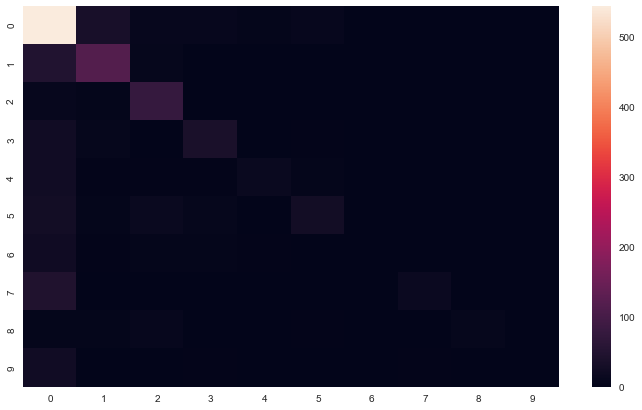

In [23]:
#Confusion matrix ...
import visu_utils as vu
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_labels,predictions)
vu.plot_confusion_mat(mat, [12,7])
print(mat)

## 5. Discussion/Conclusions

Accuracy and LogLoss both work as performance measures. Minimizing LogLoss maximizes accuracy for the most part, with some small differences in how they function. LogLoss, for example, heavily penalizes low probability predictions for correct classes. Now we're dealing with an imbalanced dataset which affects the behavior of these measures. For example, neither are robust to imbalance, and should be modified to penalize misclassification of minority classes harder. [6]

The results seem plausible in our opinion. The classifier might not be the best possible, but it gives a decent end result. What was difficult was knowing how to improve performance. A lot of the time, progress seemed to be going one steps forward - two steps back. It was easy to read from literature what one should do - but then implementing it didn't immediately give better results. It took a lot of trial and error to reach the current accuracy.

The study did answer our questions. It is possible to train a classifier to classify music into genres, using the extracted features and the 'bag-of-frames' model. For future research it would be interesting to try to apply the same techniques to a 'personally curated' playlist. In this project, we have just had to trust the labeler about which genre is correct. However, many musical pieces combine genres and borrow elements from others. Having a hard label for this kind of music seems a bit unwise. It would be possible to reframe the same concept as a multiclass classification problem, and it could yield different results in performance.

A lot could probably be improved in our model, for example, using deep neural networks instead of support vector machines, or manipulating the dataset in some other way which we didn't include. However, considering how far SVMs could be taken with this dataset, I think we performed decently.

## 6. References

*List of all the references cited in the document*  
[1] K. Neeraj. Using support vector machines effectively. 2014. https://neerajkumar.org/writings/svm/  
[2] L. Latha, S.Thangasamy. Efficient approach to Normalization of Multimodal biometric scores.  
[3] A. More. Survey of resampling techniques for improving classification performance in unbalanced datasets. 2016. arXiv:1608.06048v1  
[4] A. Jung. Machine Learning: Basic Principles. 2018. p.29  
[5] A. Jung. Machine Learning: Basic Principles. 2018. p.31  
[6] A.B. Collier. Making Sense of Logarithmic Loss. 2015. https://datawookie.netlify.com/blog/2015/12/making-sense-of-logarithmic-loss/  

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *